In [1]:
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.transforms as transforms
import subprocess
import astropy.units as u
from synphot import SpectralElement, Empirical1D, SourceSpectrum, Observation

from model_W0116_spec import model_W0116_spec
from polModel import PolModel

import os
gd_folder = os.getcwd()+"/../Calculations/Gas_and_dust/"

import sys 
sys.path.append(gd_folder)
from polWaveDust import PolWaveDust
from polWaveGas import PolWaveGas

sys.path.append("../plots/utility_functions/")
from objectProperties import ObjectProperties
from readExtrapolatedSpectra import ReadExtrapolatedSpectra

sys.path.append("../Filter_Curves/")
from readBands import ReadBands

In [2]:
#Load the properties of the BHDs
wid = "W0116-0505"
op = ObjectProperties([wid])

In [3]:
#Change the values of v-band pol in W0116 to what we would have if there is no polarization in Lyalpha. This is calculated in the notebook in plots/SKIRTOR_fit_mildly_polarized/fit_pfrac.ipynb.
op.pfrac['W0116-0505']['R_SPECIAL']  = 13.100357916861746
op.epfrac['W0116-0505']['R_SPECIAL'] = 0.29166591517341806
op.pfrac['W0116-0505']['I_BESS']     = 14.360749359163423
op.epfrac['W0116-0505']['I_BESS']    = 0.4300344256880632
op.pfrac['W0116-0505']['v_HIGH']     = 15.275949867410766
op.epfrac['W0116-0505']['v_HIGH']    = 0.845207997752401
#R_SPECIAL 11.11 0.22 13.100357916861746 0.29166591517341806
#I_BESS 14.36 0.43 14.360749359163423 0.4300344256880632
#v_HIGH 9.62 0.38 15.275949867410766 0.845207997752401

In [4]:
#Load the bands.
bands = ReadBands()
for bname in bands.bandnames:
    print(bname, bands.bp[bname].barlam(), bands.bp[bname].fwhm(), bands.bp[bname].rectwidth())

R_SPECIAL 6501.229535920617 Angstrom 1159.881393925198 Angstrom 1624.9974574790472 Angstrom
I_BESS 7925.773360798338 Angstrom 1080.5202412457434 Angstrom 1433.1539789444323 Angstrom
v_HIGH 5531.691038305597 Angstrom 850.6231300284223 Angstrom 1195.0838113345558 Angstrom


In [5]:
#Load the spectra for each BHD, extended using the best-fit SED, although here we will not care about the extension.
specs = ReadExtrapolatedSpectra()

Wavelength range for object W0019-1046 limited because of sky template
Spec-range: 3001.5 Angstrom - 5423.93 Angstrom
Sky-range: 3199.4 Angstrom - 6724.06 Angstrom
Wavelength range for object W0204-0506 limited because of sky template
Spec-range: 3786.2 Angstrom - 6672.70 Angstrom
Sky-range: 3789.3 Angstrom - 6682.76 Angstrom
Warning, 2 of 3161 bins contained negative fluxes; they have been set to zero.
Wavelength range for object W0831+0140 limited because of sky template
Spec-range: 3786.2 Angstrom - 6672.45 Angstrom
Sky-range: 3789.3 Angstrom - 6682.76 Angstrom
Warning, 2 of 3161 bins contained negative fluxes; they have been set to zero.


## Spectrum, spectrum model and general pol model object

In [6]:
#Load the spectrum. 
spec, spec_model = model_W0116_spec(specs)

In [7]:
full_spec = SourceSpectrum(Empirical1D, points=spec.lam_obs, lookup_table=spec.flam, keep_neg=True)

In [8]:
pol_model = PolModel(spec, spec_model, bands, op)

In [9]:
#Dictionaries to save the results.
xopt_all  = dict()
mod_p_all = dict() 
mod_chi_all = dict()

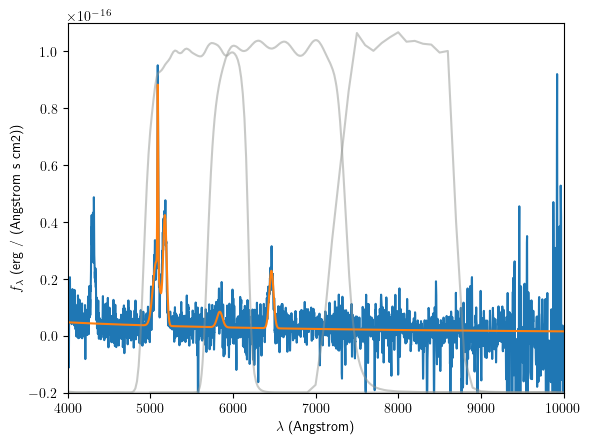

In [10]:
#Plot the spectrum, the best-fit model, and the filter curves.
pol_model.spec_plot()

(-5e-17, 5e-17)

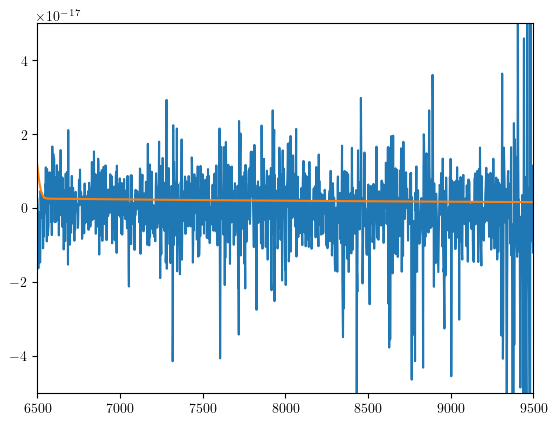

In [11]:
plt.plot(spec.lam_obs, spec.flam-spec_model.flam_model(spec.lam_rest))
plt.plot(spec.lam_obs, spec_model.flam_model(spec.lam_rest))
plt.xlim([6500, 9500])
plt.ylim([-5e-17, 5e-17])

In [12]:
#General plotting function
def pol_plot(mod_p, spec, pol_model, fmt="ko", show_legend=True):

    # data = np.loadtxt("pol_measurements.dat", usecols=[1,2])
    # p_measured = data[:,0]
    # p_unc = data[:,1]
    p_measured =pol_model.p_measured
    p_unc = pol_model.p_unc

    wave = np.array([5500., 6500., 8000.]) / spec.zspec

    fig, ax = plt.subplots(1)

    #ax.errorbar(wave, p_measured, yerr=p_unc, fmt='ko', label='Measurements')
    ax.errorbar(wave, p_measured, yerr=p_unc, fmt=fmt, label='Measurements')
    for scat_type in mod_p.keys():
        if scat_type[-3:]=="LMC":
            fmt = '^'
        elif scat_type[-3:]=="SMC":
            fmt = 's'
        elif scat_type[-2:]=="MW":
            fmt = 'P'
        else:
            fmt='p'

        ax.plot(wave, mod_p[scat_type], fmt, label=scat_type)

    if show_legend:
        ax.legend(ncol=3)
    ax.set_xlabel('Wavelength (Angstroms)')
    ax.set_ylabel('Polarization fraction')
    plt.show()

## Pure Gas Polarization

#### Same inclination for Continuum and Lines

In [13]:
#Define the scattering object
class Gas_Gas(object):

    def __init__(self):

        #Set the number of parameters for the continuum (a) and the lines (b). The order in x is always: delta_chi, a model parameters, b model parameters (if any).
        self.npar_a = 2

        #Load the simple gas model. 
        self.gas_obj = PolWaveGas()

        return

    #In this model, the continuum and emission line polarization fraction is forced to be the same. 
    def pfrac(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta = a_pars[0]
        psi = a_pars[1]
        return self.gas_obj.p(([theta],[psi])).flatten()[0] * np.ones(len(lam))
    
    #Continuum polarization fraction    
    def pfrac_A(self, x, lam):
        return self.pfrac(x, lam)

    #Line polarization fraction    
    def pfrac_B(self, x, lam):
        return self.pfrac(x, lam)

In [14]:
scat_obj = Gas_Gas()

##### Force the same polarization angle. 

In [15]:
x0 = np.array([0., 80., 50.])
min_vals = np.array([0., 0., 0.])
max_vals = np.array([0., 90., 90.])
pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
#pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

mname = "GG0"
xopt_all[mname]  = pol_model.xopt
mod_p_all[mname] = pol_model.mod_p
mod_chi_all[mname] = pol_model.mod_chi

`xtol` termination condition is satisfied.
[-5.07057118e-22  7.49497185e+01  7.29161019e+01]
50.53560662822088


##### Allow for different polarization angles.

In [16]:
x0 = np.array([0., 80., 50.])
min_vals = np.array([0., 0., 0.])
max_vals = np.array([90., 90., 90.])
pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
#pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

mname = "GG1"
xopt_all[mname]  = pol_model.xopt
mod_p_all[mname] = pol_model.mod_p
mod_chi_all[mname] = pol_model.mod_chi

`xtol` termination condition is satisfied.
[17.6033987  71.78734507 72.00185089]
49.412004385492516


In [17]:
x0 = np.array([40., 60., 70.])
min_vals = np.array([0., 0., 0.])
max_vals = np.array([90., 90., 90.])
pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
#pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

mname = "GG1"
xopt_all[mname]  = pol_model.xopt
mod_p_all[mname] = pol_model.mod_p
mod_chi_all[mname] = pol_model.mod_chi

`xtol` termination condition is satisfied.
[17.60338781 60.442211   68.81899635]
49.41200438548677


#### Allow for independent torus opening angles for lines and continuum.

I *believe* that a scatterer very near the accretion disk should be able to be modeled by allowing for different opening angles, which in that model would just simply become for the lines the size of the BLR ring shining into a small scatterer, and for the continuum it would become the covering angle by the scatterer.

In [18]:
#Define the scattering object
class Gas_Gas(object):

    def __init__(self):

        #Set the number of parameters for the continuum (a) and the lines (b). The order in x is always: delta_chi, a model parameters, b model parameters (if any).
        self.npar_a = 2
        self.npar_b = 1

        #Load the simple gas model. 
        self.gas_obj = PolWaveGas()

        return

    #In this model, the continuum and emission line polarization fraction is forced to be the same. 
    def pfrac_A(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta = a_pars[0]
        psi_A = a_pars[1]
        return self.gas_obj.p(([theta],[psi_A])).flatten()[0] * np.ones(len(lam))
    
    #Emission line polarization.
    def pfrac_B(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta = a_pars[0]
        b_pars = x[self.npar_a+1:]
        psi_B = b_pars[0]
        return self.gas_obj.p(([theta],[psi_B])).flatten()[0] * np.ones(len(lam))
    

In [19]:
scat_obj = Gas_Gas()

In [20]:
x0 = np.array([0., 80., 50., 50.])
min_vals = np.array([0., 0., 0., 0.])
max_vals = np.array([90., 90., 90., 90.])
pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
#pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

mname = "GG2"
xopt_all[mname]  = pol_model.xopt
mod_p_all[mname] = pol_model.mod_p
mod_chi_all[mname] = pol_model.mod_chi

`xtol` termination condition is satisfied.
[84.08503912 71.80714507 71.83074638  3.77146843]
6.474022804607476e-11


In [21]:
pol_model.mod_chi.to(u.deg)

<Quantity [8.16351983e+01, 7.94358742e+01, 1.33545380e-03] deg>

Now, force the polarization angle to be the same, as suggested by the edge on view of Zakamska & Alexandroff (2023).

In [22]:
x0 = np.array([0., 80., 30., 70.])
min_vals = np.array([0., 0., 0., 0.])
max_vals = np.array([0., 90., 90., 90.])
pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
#pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

mname = "GG3"
xopt_all[mname]  = pol_model.xopt
mod_p_all[mname] = pol_model.mod_p
mod_chi_all[mname] = pol_model.mod_chi

`xtol` termination condition is satisfied.
[-3.54646646e-34  5.50788149e+01  6.65686233e+01  6.80497776e+01]
50.177015282704005


In [23]:
scat_obj.pfrac_A(pol_model.xopt.x, [1]), scat_obj.pfrac_B(pol_model.xopt.x, [1])

(array([0.14029166]), array([0.129609]))

Now allow for the polarization angle to change, but force the inclination angle to be 90 degrees. 

In [24]:
x0 = np.array([0., 90., 30., 70.])
min_vals = np.array([0., 90., 0., 0.])
max_vals = np.array([90., 90., 90., 90.])
pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
#pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

mname = "GG4"
xopt_all[mname]  = pol_model.xopt
mod_p_all[mname] = pol_model.mod_p

`gtol` termination condition is satisfied.
[84.08515064 90.         73.46940453 25.57026998]
9.499336930187124e-12


In [25]:
scat_obj.pfrac_A(pol_model.xopt.x, [1]), scat_obj.pfrac_B(pol_model.xopt.x, [1])

(array([0.14364838]), array([0.81904068]))

In [26]:
pol_model.mod_p

<Quantity [0.1527595 , 0.13100358, 0.14360751]>

In [27]:
pol_model.mod_chi.to(u.deg)

<Quantity [8.16353564e+01, 7.94360727e+01, 1.33542980e-03] deg>

## Pure dust polarization

In [28]:
dust_types = ["SMC", "LMC", "MW"]

#### Require the same polarization for the continuum and the emission lines.

In [29]:
#Define the scattering object
class Dust_Dust(object):

    def __init__(self, dust_type, fw=True, bw=True):

        #Save the input parameters.
        self.dust_type = dust_type
        self.fw = fw
        self.bw = bw

        #Set the number of parameters for the continuum (a) and the lines (b). The order in x is always: delta_chi, a model parameters, b model parameters (if any).
        self.npar_a = 2

        #Load the simple gas model. 
        self.dust_obj = PolWaveDust(self.dust_type, fw=self.fw, bw=self.bw)

        return

    #In this model, the continuum and emission line polarization fraction is forced to be the same. 
    def pfrac(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta = a_pars[0] * np.ones(len(lam))
        psi = a_pars[1] * np.ones(len(lam))
        return self.dust_obj.p((lam.to(u.AA).value, theta, psi)).flatten()
    
    #Continuum polarization fraction    
    def pfrac_A(self, x, lam):
        return self.pfrac(x, lam)

    #Line polarization fraction    
    def pfrac_B(self, x, lam):
        return self.pfrac(x, lam)

##### Force the same polarization angle. 

In [30]:
for dust_type in dust_types:
    print(dust_type)

    x0 = np.array([0., 80., 45.])
    min_vals = np.array([0., 0., 0.])
    max_vals = np.array([0., 90., 90.])

    #Consider forward+backward, forward and backward only options.
    for i in range(3):
        suffix = ""
        if i==0:
            fw=True
            bw=True
            suffix="FWBW"
        elif i==1:
            fw=True
            bw=False
            suffix="FW"
        else:
            fw=False
            bw=True
            suffix="BW"
        print(suffix)
        scat_obj = Dust_Dust(dust_type, fw=fw, bw=bw)
        pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
        #pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

        mname = "DD0_"+suffix+"_"+dust_type
        if mname not in xopt_all or pol_model.xopt.fun < xopt_all[mname].fun:
            xopt_all[mname]  = pol_model.xopt
            mod_p_all[mname] = pol_model.mod_p
            mod_chi_all[mname] = pol_model.mod_chi

    print()

SMC
FWBW
`xtol` termination condition is satisfied.
[2.82214860e-22 6.93722276e+01 4.64963335e+01]
528.6354269516346
FW
`xtol` termination condition is satisfied.
[2.47166091e-26 4.62580269e+01 9.99999992e-01]
421.16608852143173
BW
`gtol` termination condition is satisfied.
[-3.09292241e-18  9.00000000e+01  5.47559067e+01]
536.1560827833551

LMC
FWBW
`xtol` termination condition is satisfied.
[7.12329492e-25 6.86337159e+01 4.68986396e+01]
801.5798478047296
FW
`xtol` termination condition is satisfied.
[-3.9821264e-25  4.3500000e+01  2.9153773e-01]
594.0934993000346
BW
`gtol` termination condition is satisfied.
[4.62373003e-21 8.99999997e+01 5.60033906e+01]
803.7259867977306

MW
FWBW
`xtol` termination condition is satisfied.
[-9.11782092e-24  4.25649130e+01  1.76062509e-07]
352.1034061180589
FW
`xtol` termination condition is satisfied.
[-2.62000289e-24  4.31892796e+01  4.34406174e-06]
228.24874347960196
BW
`gtol` termination condition is satisfied.
[-3.27232549e-27  9.00000000e+01  5.

##### Allow for different polarization angles. 

In [31]:
for dust_type in dust_types:
    print(dust_type)

    x0 = np.array([0., 80., 45.])
    min_vals = np.array([0., 0., 0.])
    max_vals = np.array([90., 90., 90.])

    #Consider forward+backward, forward and backward only options.
    for i in range(3):
        suffix = ""
        if i==0:
            fw=True
            bw=True
            suffix="FWBW"
        elif i==1:
            fw=True
            bw=False
            suffix="FW"
        else:
            fw=False
            bw=True
            suffix="BW"
        print(suffix)
        scat_obj = Dust_Dust(dust_type, fw=fw, bw=bw)
        pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
        #pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

        mname = "DD1_"+suffix+"_"+dust_type
        if mname not in xopt_all or pol_model.xopt.fun < xopt_all[mname].fun:
            xopt_all[mname]  = pol_model.xopt
            mod_p_all[mname] = pol_model.mod_p
            mod_chi_all[mname] = pol_model.mod_chi

    print()

SMC
FWBW
`xtol` termination condition is satisfied.
[8.16586144e+01 8.35000000e+01 3.40329600e-02]
70.14055619965201
FW
`xtol` termination condition is satisfied.
[80.270043   83.49999919  0.18913346]
59.15153667925773
BW
`xtol` termination condition is satisfied.
[81.89375317 89.99784523  8.49999999]
71.24885190437158

LMC
FWBW
`xtol` termination condition is satisfied.
[78.42772913 81.          0.43083785]
402.84774971218445
FW
`xtol` termination condition is satisfied.
[6.39501469e+01 6.10000000e+01 1.34126949e-02]
388.35249400222
BW
`xtol` termination condition is satisfied.
[78.87108245 89.99865722 11.        ]
421.7242553170645

MW
FWBW
`xtol` termination condition is satisfied.
[48.45921037 50.9999998   0.14801266]
283.4346978192896
FW
`xtol` termination condition is satisfied.
[59.97034526 58.49999996  0.18166644]
77.88748939299025
BW
`xtol` termination condition is satisfied.
[73.91313216 89.99739982 13.49999995]
135.68732978227266



Now, force the polarization angle to be the same between lines and gas, but allow for the polarization fraction (opening angle) to be different. 

In [32]:
#Define the scattering object
class Dust_Dust(object):

    def __init__(self, dust_type, fw=True, bw=True):

        #Save the input parameters.
        self.dust_type = dust_type
        self.fw = fw
        self.bw = bw

        #Set the number of parameters for the continuum (a) and the lines (b). The order in x is always: delta_chi, a model parameters, b model parameters (if any).
        self.npar_a = 2

        #Load the simple gas model. 
        self.dust_obj = PolWaveDust(self.dust_type, fw=self.fw, bw=self.bw)

        return

    #In this model, the continuum and emission line polarization fraction is forced to be the same. 
    def pfrac_A(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta = a_pars[0] * np.ones(len(lam))
        psi_A = a_pars[1] * np.ones(len(lam))
        return self.dust_obj.p((lam.to(u.AA).value, theta, psi_A)).flatten()

    #Line polarization fraction    
    def pfrac_B(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta = a_pars[0] * np.ones(len(lam))
        b_pars = x[self.npar_a+1:]
        psi_B = b_pars[0]
        return self.dust_obj.p((lam.to(u.AA).value, theta, psi_B)).flatten()

In [33]:
for dust_type in dust_types:
    print(dust_type)

    x0 = np.array([0., 80., 45., 45.])
    min_vals = np.array([0., 0., 0., 0.])
    max_vals = np.array([0., 90., 90., 90.])

    #Consider forward+backward, forward and backward only options.
    for i in range(3):
        suffix = ""
        if i==0:
            fw=True
            bw=True
            suffix="FWBW"
        elif i==1:
            fw=True
            bw=False
            suffix="FW"
        else:
            fw=False
            bw=True
            suffix="BW"
        print(suffix)
        scat_obj = Dust_Dust(dust_type, fw=fw, bw=bw)
        pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
        #pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

        mname = "DD2_"+suffix+"_"+dust_type
        if mname not in xopt_all or pol_model.xopt.fun < xopt_all[mname].fun:
            xopt_all[mname]  = pol_model.xopt
            mod_p_all[mname] = pol_model.mod_p
            mod_chi_all[mname] = pol_model.mod_chi

    print()

SMC
FWBW
`xtol` termination condition is satisfied.
[3.01057059e-22 7.79409359e+01 3.85454162e+01 8.98553391e+01]
323.26708636750305
FW
`xtol` termination condition is satisfied.
[-3.10402820e-22  5.75233028e+01  9.06722191e-01  8.03787026e+01]
236.12561728566746
BW
`xtol` termination condition is satisfied.
[8.60337653e-25 8.99999508e+01 4.20393893e+01 8.97867147e+01]
326.33062048528075

LMC
FWBW
`xtol` termination condition is satisfied.
[5.34961790e-23 7.60000014e+01 3.83649895e+01 8.98607351e+01]
661.752334503553
FW
`xtol` termination condition is satisfied.
[-1.17858489e-23  5.38271583e+01  1.97334578e-01  7.75714464e+01]
426.345185433113
BW
`xtol` termination condition is satisfied.
[-3.31725488e-26  8.99990712e+01  4.27856860e+01  8.97243948e+01]
673.4845591391332

MW
FWBW
`xtol` termination condition is satisfied.
[-7.08846731e-28  6.25549986e+01  2.10000000e+01  8.99143469e+01]
285.3808476203297
FW
`xtol` termination condition is satisfied.
[-3.33678438e-28  5.35098768e+01  2.

## Gas and Dust polarization 

##### Require the same inclination

In [34]:
#Define the scattering object
class Gas_Dust(object):

    def __init__(self, dust_type, fw=True, bw=True):

        #Save the input parameters.
        self.dust_type = dust_type
        self.fw = fw
        self.bw = bw

        #Set the number of parameters for the continuum (a) and the lines (b). The order in x is always: delta_chi, a model parameters, b model parameters (if any).
        self.npar_a = 2
        self.npar_b = 1

        #Load the simple gas model. 
        self.dust_obj = PolWaveDust(self.dust_type, fw=self.fw, bw=self.bw)
        self.gas_obj = PolWaveGas(fw=self.fw, bw=self.bw)

        return

    #Continuum polarization
    def pfrac_A(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta = a_pars[0] * np.ones(len(lam))
        psi_A = a_pars[1] * np.ones(len(lam))
        return self.dust_obj.p((lam.to(u.AA).value, theta, psi_A)).flatten()
    
    #Lines polarization.
    def pfrac_B(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta = a_pars[0] * np.ones(len(lam))
        b_pars = x[self.npar_a+1:]
        psi_B = b_pars[0] * np.ones(len(lam))
        return self.dust_obj.p((lam.to(u.AA).value, theta, psi_B)).flatten()
    

In [35]:
for dust_type in dust_types:
    print(dust_type)

    x0 = np.array([0., 80., 45., 45.])
    min_vals = np.array([0., 0., 0., 0.])
    max_vals = np.array([90., 90., 90., 90.])

    #Consider forward+backward, forward and backward only options.
    for i in range(3):
        suffix = ""
        if i==0:
            fw=True
            bw=True
            suffix="FWBW"
        elif i==1:
            fw=True
            bw=False
            suffix="FW"
        else:
            fw=False
            bw=True
            suffix="BW"
        print(suffix)
        scat_obj = Gas_Dust(dust_type, fw=fw, bw=bw)
        pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
        #pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

        mname = "DG1_"+suffix+"_"+dust_type
        if mname not in xopt_all or pol_model.xopt.fun < xopt_all[mname].fun:
            xopt_all[mname]  = pol_model.xopt
            mod_p_all[mname] = pol_model.mod_p
            mod_chi_all[mname] = pol_model.mod_chi

    print()

SMC
FWBW
`xtol` termination condition is satisfied.
[ 4.17023147 78.20937023 38.70234738 89.85419638]
323.2672217909066
FW
`xtol` termination condition is satisfied.
[ 7.39846068 57.51885136  0.96846277 80.37771042]
236.12859110077622
BW
`xtol` termination condition is satisfied.
[ 2.09844121 89.9999545  42.04628737 89.78671343]
326.3307962354061

LMC
FWBW
`xtol` termination condition is satisfied.
[ 6.22007537 75.99999989 38.36479921 89.86073485]
661.7523598506853
FW
`xtol` termination condition is satisfied.
[ 4.17488597 53.81187171  0.21868455 77.5672459 ]
426.3492361385987
BW
`xtol` termination condition is satisfied.
[ 4.74241012 89.9999743  42.79012545 89.72402527]
673.4735328594174

MW
FWBW
`xtol` termination condition is satisfied.
[ 3.82288412 62.55851958 20.99999985 89.91433732]
285.38083404066833
FW
`xtol` termination condition is satisfied.
[ 4.40317512 53.51770563  0.23816292 74.94862921]
94.45842092637959
BW
`xtol` termination condition is satisfied.
[ 5.02577372 89.99953

##### Allow for different inclinations

In [36]:
#Define the scattering object
class Gas_Dust(object):

    def __init__(self, dust_type, fw=True, bw=True):

        #Save the input parameters.
        self.dust_type = dust_type
        self.fw = fw
        self.bw = bw

        #Set the number of parameters for the continuum (a) and the lines (b). The order in x is always: delta_chi, a model parameters, b model parameters (if any).
        self.npar_a = 2
        self.npar_b = 2

        #Load the simple gas model. 
        self.dust_obj = PolWaveDust(self.dust_type, fw=self.fw, bw=self.bw)
        self.gas_obj = PolWaveGas(fw=self.fw, bw=self.bw)

        return

    #Continuum polarization
    def pfrac_A(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta_A = a_pars[0] * np.ones(len(lam))
        psi_A   = a_pars[1] * np.ones(len(lam))
        return self.dust_obj.p((lam.to(u.AA).value, theta_A, psi_A)).flatten()
    
    #Lines polarization.
    def pfrac_B(self, x, lam):
        b_pars = x[self.npar_a+1:]
        theta_B = b_pars[0] * np.ones(len(lam))
        psi_B   = b_pars[1] * np.ones(len(lam))
        return self.dust_obj.p((lam.to(u.AA).value, theta_B, psi_B)).flatten()
    

In [37]:
for dust_type in dust_types:
    print(dust_type)

    x0 = np.array([0., 80., 45., 80., 45.])
    min_vals = np.array([0., 0., 0., 0., 0.])
    max_vals = np.array([90., 90., 90., 90., 90.])

    #Consider forward+backward, forward and backward only options.
    for i in range(3):
        suffix = ""
        if i==0:
            fw=True
            bw=True
            suffix="FWBW"
        elif i==1:
            fw=True
            bw=False
            suffix="FW"
        else:
            fw=False
            bw=True
            suffix="BW"
        print(suffix)
        scat_obj = Gas_Dust(dust_type, fw=fw, bw=bw)
        pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
        #pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

        mname = "DG2_"+suffix+"_"+dust_type
        if mname not in xopt_all or pol_model.xopt.fun < xopt_all[mname].fun:
            xopt_all[mname]  = pol_model.xopt
            mod_p_all[mname] = pol_model.mod_p
            mod_chi_all[mname] = pol_model.mod_chi

    print()

SMC
FWBW
`xtol` termination condition is satisfied.
[ 4.10013645 78.14048491 38.66157254 57.61585679 89.91737238]
323.2679337092869
FW
`xtol` termination condition is satisfied.
[16.17807276 57.51812417  0.89635345 49.13148805 78.50841055]
236.14751341936037
BW
`xtol` termination condition is satisfied.
[ 3.70027581 89.99396794 42.04801136 89.56278831 89.93034615]
326.3690106044647

LMC
FWBW
`xtol` termination condition is satisfied.
[ 2.61555814 76.         38.36479465 57.72956072 89.92593268]
661.7530751075886
FW
`xtol` termination condition is satisfied.
[2.14372566e+00 5.38102241e+01 1.79672614e-02 4.75688847e+01
 7.61013286e+01]
426.32783285488375
BW
`xtol` termination condition is satisfied.
[ 3.41832376 89.99637865 42.80022299 89.94506744 89.74645186]
673.518644117851

MW
FWBW
`xtol` termination condition is satisfied.
[ 1.90100703 62.55569768 21.         54.2432607  89.95561135]
285.39086476608236
FW
`xtol` termination condition is satisfied.
[ 8.11787821 53.51858881  0.2826296

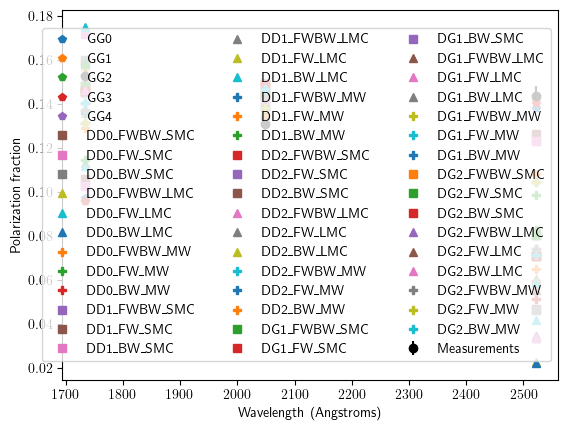

In [38]:
pol_plot(mod_p_all, spec, pol_model)

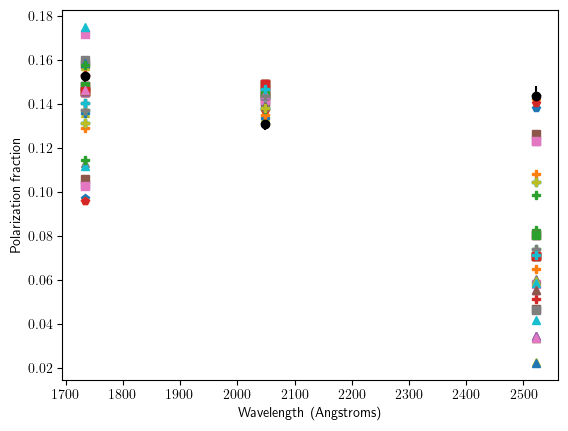

In [39]:
pol_plot(mod_p_all, spec, pol_model, show_legend=False)

In [40]:
#Rank solutions from best to worse. 
model_names = list(xopt_all.keys())
fun_all = np.zeros(len(model_names))
for i, mname in enumerate(model_names):
    fun_all[i] = xopt_all[mname].fun
k = np.argsort(fun_all)
for kk in k:
    mname = model_names[kk]
    print(mname, xopt_all[mname].fun, xopt_all[mname].x)

GG4 9.499336930187124e-12 [84.08515064 90.         73.46940453 25.57026998]
GG2 6.474022804607476e-11 [84.08503912 71.80714507 71.83074638  3.77146843]
GG1 49.41200438548677 [17.60338781 60.442211   68.81899635]
GG3 50.177015282704005 [-3.54646646e-34  5.50788149e+01  6.65686233e+01  6.80497776e+01]
GG0 50.53560662822088 [-5.07057118e-22  7.49497185e+01  7.29161019e+01]
DD1_FW_SMC 59.15153667925773 [80.270043   83.49999919  0.18913346]
DD1_FWBW_SMC 70.14055619965201 [8.16586144e+01 8.35000000e+01 3.40329600e-02]
DD1_BW_SMC 71.24885190437158 [81.89375317 89.99784523  8.49999999]
DD1_FW_MW 77.88748939299025 [59.97034526 58.49999996  0.18166644]
DD2_FW_MW 94.42061172864952 [-3.33678438e-28  5.35098768e+01  2.91707180e-03  7.49458226e+01]
DG1_FW_MW 94.45842092637959 [ 4.40317512 53.51770563  0.23816292 74.94862921]
DG2_FW_MW 94.47400028695856 [ 8.11787821 53.51858881  0.28262967 52.08359486 74.53592317]
DD1_BW_MW 135.68732978227266 [73.91313216 89.99739982 13.49999995]
DD0_FW_MW 228.248743

In [41]:
pw = PolWaveGas()
for mname in ['GG2','GG4']:
    dchi, th, psi1, psi2 = xopt_all[mname].x
    print(mname, dchi, th, psi1, psi2)
    print(mname, pw.p((th, psi1)), pw.p((th, psi2)))

GG2 84.08503912084531 71.8071450665222 71.83074637659227 3.771468432893178
GG2 0.1436483733605528 0.8190401557086125
GG4 84.08515064020001 90.0 73.46940452746901 25.57026998486986
GG4 0.1436483782454363 0.8190406803867039


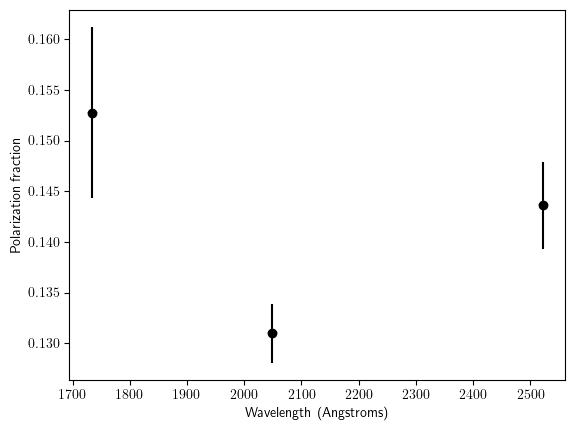

In [42]:
mod_p_show = dict()
for mname in xopt_all.keys():
    if xopt_all[mname].fun < 1.:
        mod_p_show[mname] = mod_p_all[mname]
pol_plot(mod_p_show, spec, pol_model, show_legend=False)

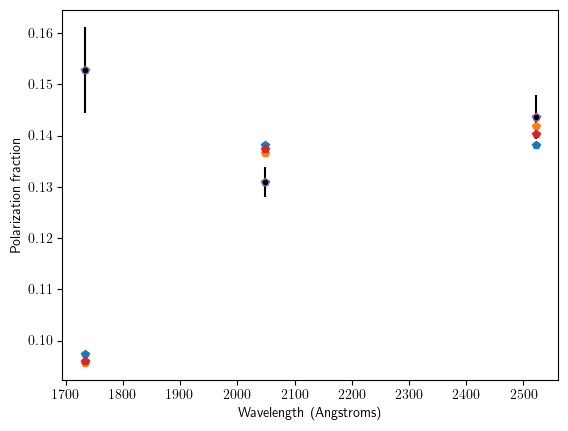

In [43]:
mod_p_gas = dict()
for mname in xopt_all.keys():
    if mname[:2]=="GG":
        mod_p_gas[mname] = mod_p_all[mname]
pol_plot(mod_p_gas, spec, pol_model, show_legend=False, fmt='k.')

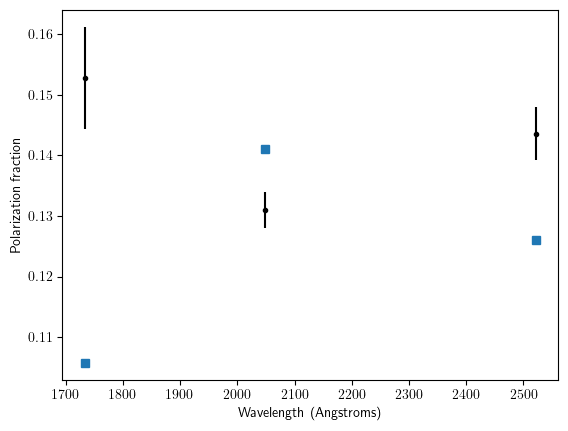

In [44]:
mod_p_dust = dict()
for mname in xopt_all.keys():
    if mname[:2]!="GG" and xopt_all[mname].fun < 70.:
        mod_p_dust[mname] = mod_p_all[mname]
pol_plot(mod_p_dust, spec, pol_model, show_legend=False, fmt='k.')